# Abstract
With this project I had the opportunity to explore web-scraping and text analysis. The aim of this notebook is to scrape some reviews for a product in a e-shop and then do a sentiment analysis and outliers detection

## Obtaining the data

Importing the libraries

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

Scraping the reviews

In [2]:
def get_page(url):
  '''
  This function returns the site corresponding to the 
  url passed and in case of fail return -1
  '''
  page = requests.get(url)
  if page.status_code == 200:
    return page
  return -1

In [5]:
def get_urls(verbose = False):
  '''
  This function returns the list of all the pages of reviews for a product
  '''
  urls = []

  i=1
  url = 'https://www.ebay.com/urw/Bose-Soundbar-500-TV-Speaker-Black-838309-1100-/product-reviews/21040313446?_itm=195988019859&condition=all&pgn=1'
  response = get_page(url)
  soup = BeautifulSoup(response.text)

  #If this element is present we passed the last review page
  while soup.find('div', {'class' : 'empty-review-section'}) == None: 
    urls.append(url)
    i = i + 1

    #Next page
    url = url[:137] + str(i)
    response = get_page(url)
    soup = BeautifulSoup(response.text)

    if (verbose) and (i%5 == 0):
      print(f"I'm at page {i}")

  print(f'No. of pages: {len(urls)}')
  return urls

In [8]:
urls = get_urls(verbose = True)

I'm at page 5
I'm at page 10
I'm at page 15
I'm at page 20
No. of pages: 21


In [9]:
def get_ds(urls):
  '''
  From each comment in a page we extract :
  -Username
  -Title
  -Review
  -Stars
  -Condition
  -Date
  All this features create a row of the dataset
  '''
  
  ds = pd.DataFrame(columns = ['User','Title', 'Review', 'Score', 'Condition', 'Date'])

  months = {'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

  for url in urls:
    response = get_page(url)
    soup = BeautifulSoup(response.text)

    for current_div in soup.find_all('div', {'class':'ebay-review-section'}):
      #Each <div> contains all about our reviews
      
      #User
      user = current_div.find('a', {'class' : 'review-item-author'}).text
      #Title
      title =  current_div.find('h3').text
      #Review-body: if not present = NA
      if current_div.find('p', {'class':'review-item-content rvw-wrap-spaces'}) != None:
        review = current_div.find('p', {'class':'review-item-content rvw-wrap-spaces'}).text.replace('\n', '')
      else:
        review = pd.NA
      #Number of stars
      stars = float(current_div.find('span', {'class' : 'star-rating'}).attrs["aria-label"][0])
      #Condition: if not present = NA
      if current_div.find('span', {'class' : 'rvw-val capitalize'}) != None:
        condition = current_div.find('span', {'class' : 'rvw-val capitalize'}).text
      else:
        condition = pd.NA
      #Date: date phasing
      date_split = current_div.find('span', {'class' : 'review-item-date'}).text.replace(',', '').split(' ')
      date_split[0] = str(months[date_split[0]])
      date = '-'.join(date_split)

      ds.loc[len(ds)] = {'User':user, 'Title':title, 'Review':review, 'Score':stars, 'Condition':condition,'Date':date}

  ds['Date'] = pd.to_datetime(ds['Date'], format = '%m-%d-%Y')

  return ds

Creating the dataset

In [10]:
ds = get_ds(urls)
ds.head()

,User,Title,Review,Score,Condition,Date
0,hm60261,Good but there are better options.,This is an entry level Bose sound bar. It has ...,4.0,new,2021-12-21
1,cochransk123,Not Special,I purchased this speaker because of the Name r...,3.0,refurbished,2023-01-18
2,swansonda,Product Meets Advertised Quality,Product provides excellent enhanced quality of...,5.0,new,2020-12-08
3,e-greg80,Broke 60 days after… He’s not authorized Bose ...,I’ll start this buy saying this is a fantastic...,3.0,new,2022-07-11
4,ghil_s2006,Somewhat defective,Not as immersive as I expected. Something not ...,2.0,pre-owned,2023-06-25


In [12]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 0 to 208
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   User       209 non-null    object        
 1   Title      209 non-null    object        
 2   Review     204 non-null    object        
 3   Score      209 non-null    float64       
 4   Condition  193 non-null    object        
 5   Date       209 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 11.4+ KB


## Data Visualization

Score histogram

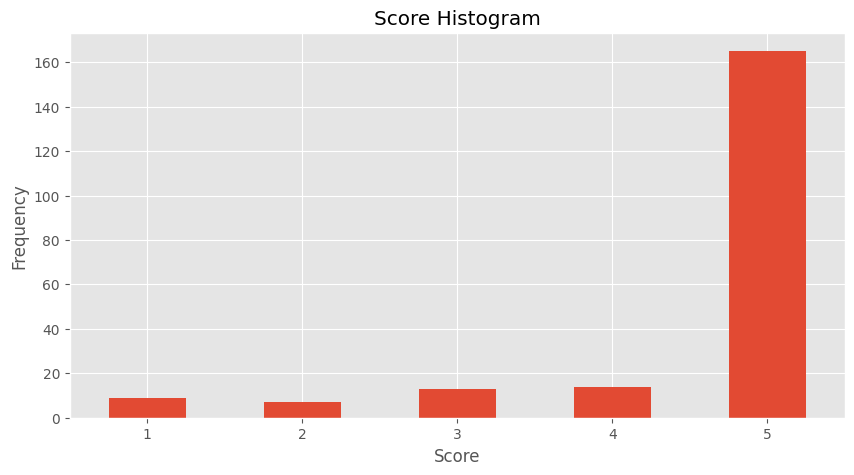

In [ ]:
ds['Score'].astype(int) \
    .value_counts().sort_index() \
    .plot(kind = 'bar',
          figsize = (10, 5),
          rot = 0,
          xlabel = 'Score',
          ylabel = 'Frequency',
          title = 'Score Histogram')
plt.show()

Score histogram for each condition

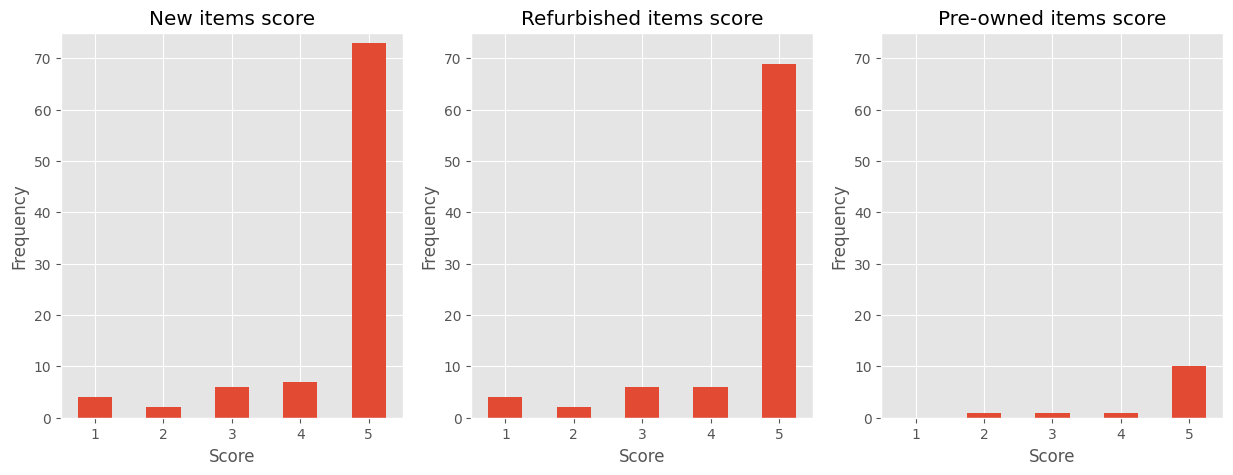

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

ds[ds['Condition'] == 'new']['Score'].value_counts().sort_index().plot(
    kind = 'bar',
    title = 'New items score',
    xlabel = 'Score',
    ylabel = 'Frequency',
    ax = ax[0]
)

ax[0].set_xticklabels([1, 2, 3, 4, 5], rotation = 0)
ax[0].set_ylim((0, 75))

ds[ds['Condition'] == 'refurbished']['Score'].value_counts().sort_index().plot(
    kind = 'bar',
    title = 'Refurbished items score',
    xlabel = 'Score',
    ylabel = 'Frequency',
    ax = ax[1]
)

ax[1].set_xticklabels([1, 2, 3, 4, 5], rotation = 0)
ax[1].set_ylim((0, 75))

ds[ds['Condition'] == 'pre-owned']['Score'].value_counts().sort_index().plot(
    kind = 'bar',
    title = 'Pre-owned items score',
    xlabel = 'Score',
    ylabel = 'Frequency',
    ax = ax[2]
)

ax[2].set_xticks([-1, 0, 1, 2, 3])
ax[2].set_xticklabels([1, 2, 3, 4, 5], rotation = 0)
ax[2].set_xlim((-1.5, 3.5))
ax[2].set_ylim((0, 75))

plt.show()

Time series of the mean score for each month

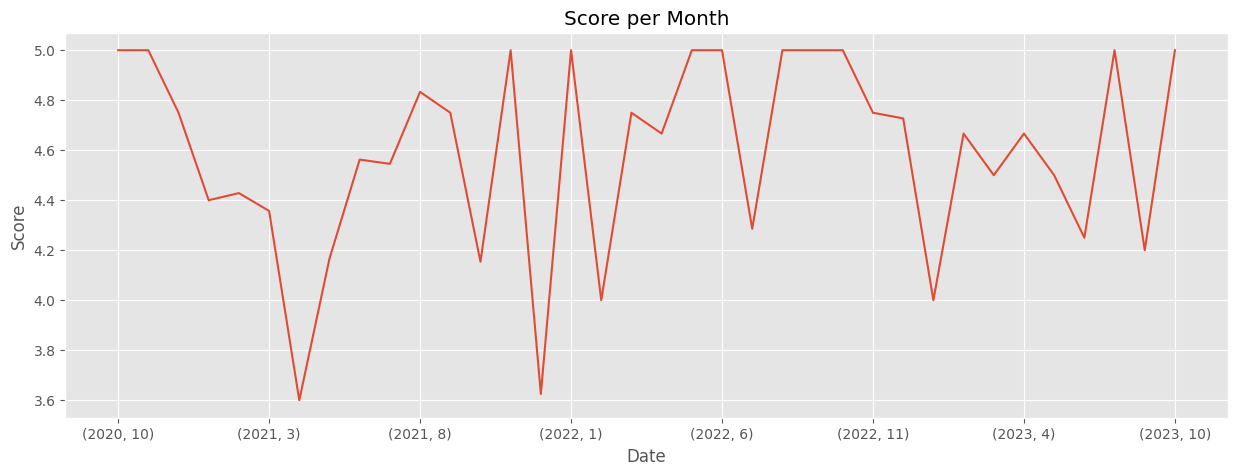

In [ ]:
ds.groupby([ds['Date'].dt.year, ds['Date'].dt.month])['Score'].mean() \
  .plot(figsize = (15, 5),
        xlabel = 'Date',
        ylabel = 'Score',
        title = 'Score per Month')
plt.show()

## Sentiment Analysis

Importing libraries

In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacop\AppData\Roaming\nltk_data...


In [15]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Good music")

{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}

Adding the sentiment info at the dataset

In [16]:
sia = SentimentIntensityAnalyzer()
'''
Getting the polarity_score (Negative, Neutral, Positive and Compound)
for each review if the review is not NA, 
and then adding it to a new column of the ds
'''
pol_scores = pd.DataFrame(columns = ["Negative", "Neutral", "Positive", "Compound"])

for review in ds['Review'].values:
  if pd.notna(review):
    pol = sia.polarity_scores(review)
    pol_scores.loc[len(pol_scores), ["Negative", "Neutral", "Positive", "Compound"]] = pol['neg'], pol['neu'], pol['pos'], pol['compound']
  else:
    pol_scores.loc[len(pol_scores), ["Negative", "Neutral", "Positive", "Compound"]] = pd.NA

ds = ds.join(pol_scores, how = 'left')

ds.head()

,User,Title,Review,Score,Condition,Date,Negative,Neutral,Positive,Compound
0,hm60261,Good but there are better options.,This is an entry level Bose sound bar. It has ...,4.0,new,2021-12-21,0.0,0.847,0.153,0.9419
1,cochransk123,Not Special,I purchased this speaker because of the Name r...,3.0,refurbished,2023-01-18,0.082,0.857,0.061,0.0772
2,swansonda,Product Meets Advertised Quality,Product provides excellent enhanced quality of...,5.0,new,2020-12-08,0.0,0.774,0.226,0.9349
3,e-greg80,Broke 60 days after… He’s not authorized Bose ...,I’ll start this buy saying this is a fantastic...,3.0,new,2022-07-11,0.031,0.825,0.145,0.9964
4,ghil_s2006,Somewhat defective,Not as immersive as I expected. Something not ...,2.0,pre-owned,2023-06-25,0.042,0.869,0.089,0.6915


Compound Distribution

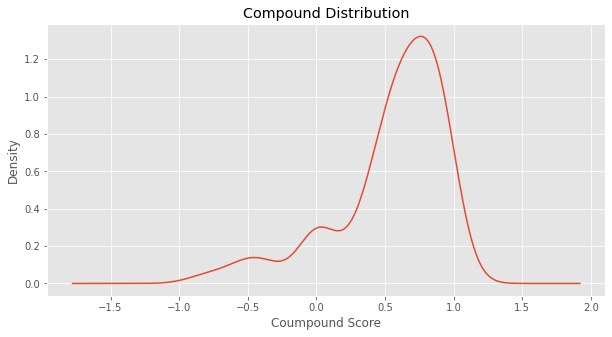

In [20]:
ds[pd.notna(ds['Compound'])]['Compound'].astype('float') \
  .plot(kind = 'kde',
        # bins = 50,
        figsize = (10, 5),
        rot = 0,
        title = 'Compound Distribution')
plt.xlabel('Compound Score')
plt.show()

Comparison between mean score per month and compound score per month

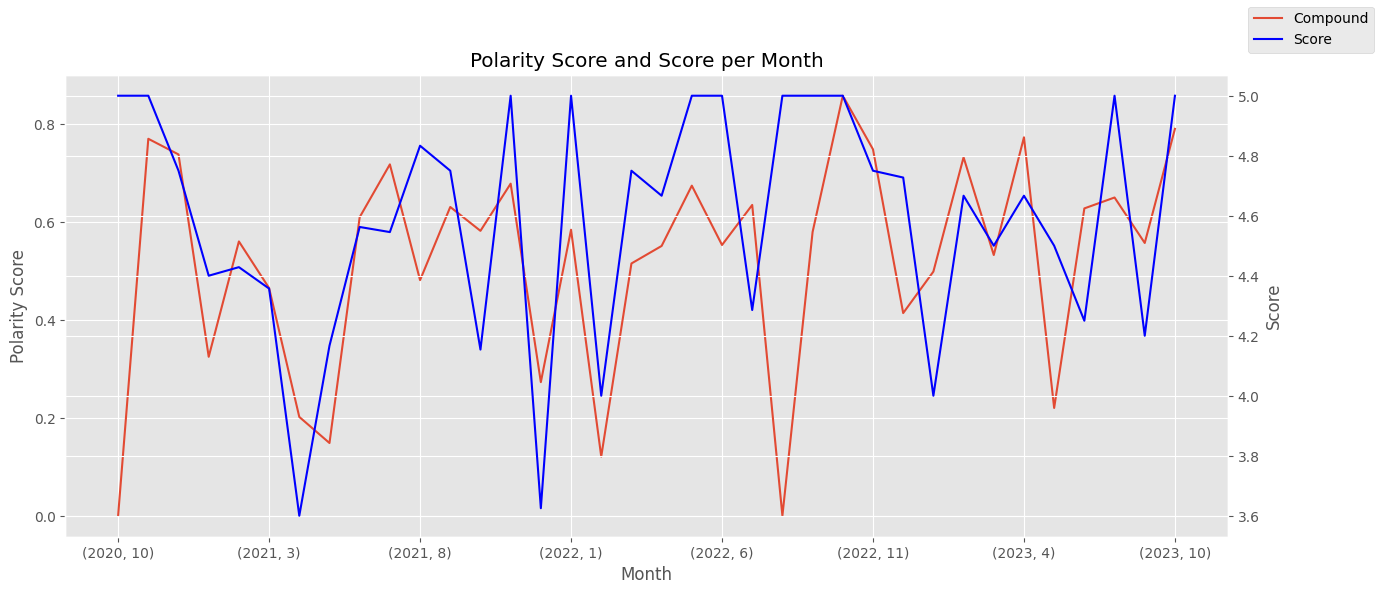

In [ ]:
fig,ax = plt.subplots()
ds.groupby([ds['Date'].dt.year, ds['Date'].dt.month])['Compound'].mean() \
  .plot(rot = 0,
        xlabel = 'Month',
        ylabel = 'Polarity Score',
        title = 'Polarity Score and Score per Month',
        ax = ax)
# plt.grid(visible=False)

ax2 = ax.twinx()
ds.groupby([ds['Date'].dt.year, ds['Date'].dt.month])['Score'].mean() \
  .plot(figsize = (15, 6),
        ylabel = 'Stars',
        color = 'blue',
        ax = ax2)
# plt.grid(visible=False)

# plt.tight_layout()
fig.legend(loc='upper right')
plt.show()

Correlation between the two scores

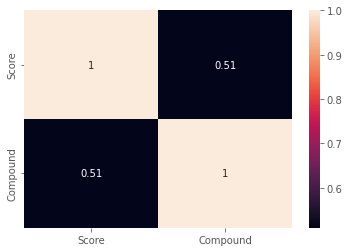

In [24]:
ds_mod = ds
ds_corr = ds_mod[['Score', 'Compound']].copy()
ds_corr = ds_corr.dropna()
ds_corr['Compound'] = ds_corr['Compound'].astype('float')

sns.heatmap(ds_corr.corr(), annot = True)
plt.show()

Outliers identification<br>
<i>Outliers in this dataset are characterized by a neutral score of 1, this happens because some comments are not written in English and/or because the polarity score function gets the classification wrong<i>

In [22]:
ds[ds['Neutral'] == 1]

,User,Title,Review,Score,Condition,Date,Negative,Neutral,Positive,Compound
89,sgarner106,sounds ridiculously incredible,the closest you can get to a surround system i...,5.0,refurbished,2021-08-17,0.0,1.0,0.0,0.0
119,mrosel80,👍👍,Grear sound for a small package and I got it a...,5.0,refurbished,2021-05-17,0.0,1.0,0.0,0.0
120,abeo_57,Nice speaker,"I have a Bose speaker for my pc, and I knee we...",4.0,new,2023-05-05,0.0,1.0,0.0,0.0
128,lam8kis,The Sound is real good!,Brought our new TV to life!,5.0,refurbished,2022-01-03,0.0,1.0,0.0,0.0
131,rofranci_43,Bose - The name sums it up,"If you know Bose, you know there is always qua...",5.0,new,2022-06-11,0.0,1.0,0.0,0.0
132,renf_lydi,Great to understand voices,I can hear and understand what the people are ...,5.0,new,2022-03-14,0.0,1.0,0.0,0.0
137,ddedde_llk94da1pc,Bose quality,Small package with big sound a quality product,5.0,pre-owned,2021-10-19,0.0,1.0,0.0,0.0
153,na9002,very satisfied,Its a Bose,5.0,new,2020-12-14,0.0,1.0,0.0,0.0
154,mbalun,Good size,As advertised,5.0,refurbished,2022-08-06,0.0,1.0,0.0,0.0
164,omugh.omugh,Great and amazing,"It’s simply the best., couldn’t think of anyth...",4.0,new,2021-03-31,0.0,1.0,0.0,0.0


Correlation between the two scores <br>
<i>this time without outliers<i>

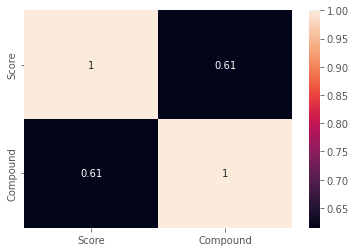

In [25]:
ds_mod = ds[ds['Neutral'] != 1]
ds_corr = ds_mod[['Score', 'Compound']].copy()
ds_corr = ds_corr.dropna()
ds_corr['Compound'] = ds_corr['Compound'].astype('float')

sns.heatmap(ds_corr.corr(), annot = True)
plt.show()